# DB12 Analysis: Port to Python 3

In [1]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, RidgeCV
from sklearn import metrics

## Problem

DB12 was written in python2 and was ported to python3 in October 21.
The CI detected discrepancies between results of DB12 when executed with python2 and python3.
In this notebook, we want to study the potential impact of the discrepancies on the execution of the jobs and propose new solutions.

### Source of the discrepancies:

Porting DB12 to python3 involved:
- using `range` instead of `xrange`: but actually `range` in python3 is the equivalent of `xrange` in python2.
- using `long` instead of `int` values: python3 does not support the old `int` anymore, the new `int` == `long`. Operations involving the new `int` are slower.
- and probably many other small optimizations...

Finding the source of the discrepancies would imply thorough profiling and would probably not help us to resolve the issue.
First let's discover the impact of such a change.

### Impact

Hypothesis: 
- $H_0$: Scores of `python3` DB12 are not significantly different from `python2` scores.
- $H_a$: Scores are significantly different.

We submitted 5 jobs computing DB12 20 times (10 with `python2` and 10 with `python3`, 5 minutes interval between each run) on many different sites and we collected data about the scores and the environments (programs available in `resources`).

```bash
# On a dirac client
./submit.sh
python getDB12Scores.py
```

## Data

In [2]:
results = ['240921', '201021']
lines = []

for result in results:
    data = {}

    with open('resources/results/results_ordered_%s.json' % result, 'r') as f:
        data = json.load(f)

    labels = ['score', 'python-version', 'os', 'cpu-model', 'nb-cores', 'cpu-mhz', 'load-avg', 'ce', 'iteration', 'job-id']
    for jobid, jobattr in data.items():
        os = jobattr['environment'].get('RedHatRelease')
        cpu_model = jobattr['environment']['CPUModel']
        cores_x_mhz = jobattr['environment']['CPUMHz'].split('x')
        nb_cores = int(cores_x_mhz[0])
        cpu_mhz = float(cores_x_mhz[1])
        load_avg = jobattr['jobparams']['LoadAverage']
        ce = jobattr['jobparams']['GridCE']
        
        for key, value in jobattr['results'].items():
            iteration = key.split('_')[0]
            python_version = value['PythonVersion']['Major']
            
            for result in value['scores']:
                score = result['NORM']
                lines.append([score, python_version, os, cpu_model, nb_cores, cpu_mhz, load_avg, ce, iteration, jobid])

df = pd.DataFrame(lines, columns=labels)
df = df.sort_values(by='cpu-model')

df

score  python-version                                    os  \
8823  17.099863               3  CentOS Linux release 7.9.2009 (Core)   
8843  11.627907               2  CentOS Linux release 7.9.2009 (Core)   
8842  15.595758               3  CentOS Linux release 7.9.2009 (Core)   
8841  17.556180               3  CentOS Linux release 7.9.2009 (Core)   
8840  11.973180               2  CentOS Linux release 7.9.2009 (Core)   
...         ...             ...                                   ...   
2347  10.490978               2  CentOS Linux release 7.7.1908 (Core)   
2346  11.927481               3  CentOS Linux release 7.7.1908 (Core)   
2345  11.938873               3  CentOS Linux release 7.7.1908 (Core)   
5484  11.190689               2  CentOS Linux release 7.9.2009 (Core)   
5483  13.206550               3  CentOS Linux release 7.9.2009 (Core)   

                                       cpu-model  nb-cores   cpu-mhz load-avg  \
8823             AMD EPYC 7282 16-Core Processor        64  2800.000    75.97   
8843             AMD EPYC 7282 16-Core Processor        64  2800.000    75.97   
8842             AMD EPYC 7282 16-Core Processor        64  2800.000    75.97   
8841             AMD EPYC 7282 16-Core Processor        64  2800.000    75.97   
8840             AMD EPYC 7282 16-Core Processor        64  2800.000    75.97   
...                                          ...       ...       ...      ...   
2347  Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz        64  2631.152    57.34   
2346  Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz        64  2631.152    57.34   
2345  Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz        64  2631.152    57.34   
5484  Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz        16  2095.074     5.97   
5483  Intel(R) Xeon(R) Silver 4216 CPU @ 2.10GHz        16  2095.074     5.97   

                      ce iteration     job-id  
8823  lapp-ce06.in2p3.fr         3  542946731  
8843  lapp-ce06.in2p3.fr         7  542946731  
8842  lapp-ce06.in2p3.fr         7  542946731  
8841  lapp-ce06.in2p3.fr         8  542946731  
8840  lapp-ce06.in2p3.fr         0  542946731  
...                  ...       ...        ...  
2347  ce03.cmsaf.mit.edu         2  534019954  
2346  ce03.cmsaf.mit.edu         3  534019954  
2345  ce03.cmsaf.mit.edu         9  534019954  
5484       ce515.cern.ch         9  534019731  
5483       ce515.cern.ch         4  534019731  

[11880 rows x 10 columns]

**Number of computed scores per cpu model and python version**

<ipython-input-3-93d1da1febc8>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(df['cpu-model'].unique(), rotation=45, horizontalalignment='right')


[]

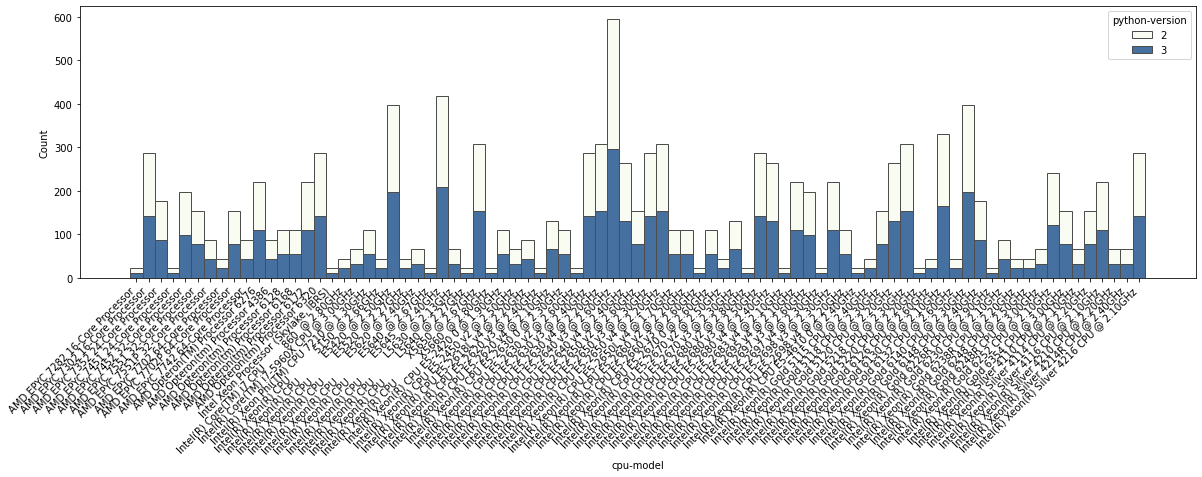

In [3]:
plt.rcParams['figure.figsize'] = [20, 5]
plot = sns.histplot(
    df,
    x="cpu-model",
    hue="python-version",
    multiple="stack",
    palette="GnBu",
    edgecolor=".3",
)

plot.set_xticklabels(df['cpu-model'].unique(), rotation=45, horizontalalignment='right')
plot.plot()

**Number of computed scores per CE and python version**

<ipython-input-4-e113547fa5ac>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(df['ce'].unique(), rotation=45, horizontalalignment='right')


[]

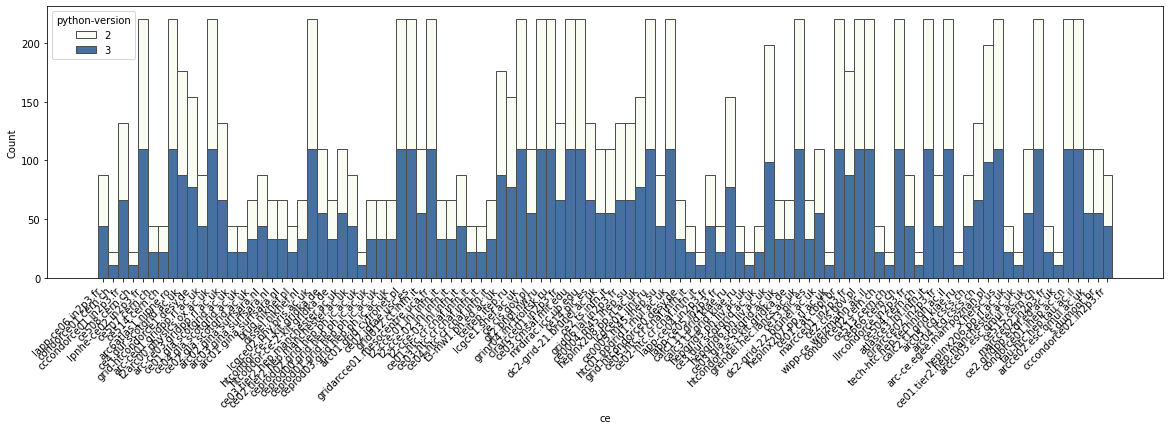

In [4]:
plt.rcParams['figure.figsize'] = [20, 5]
plot = sns.histplot(
    df,
    x="ce",
    hue="python-version",
    multiple="stack",
    palette="GnBu",
    edgecolor=".3",
)

plot.set_xticklabels(df['ce'].unique(), rotation=45, horizontalalignment='right')
plot.plot()

**Distribution of the scores according to the cpu model and the python version**

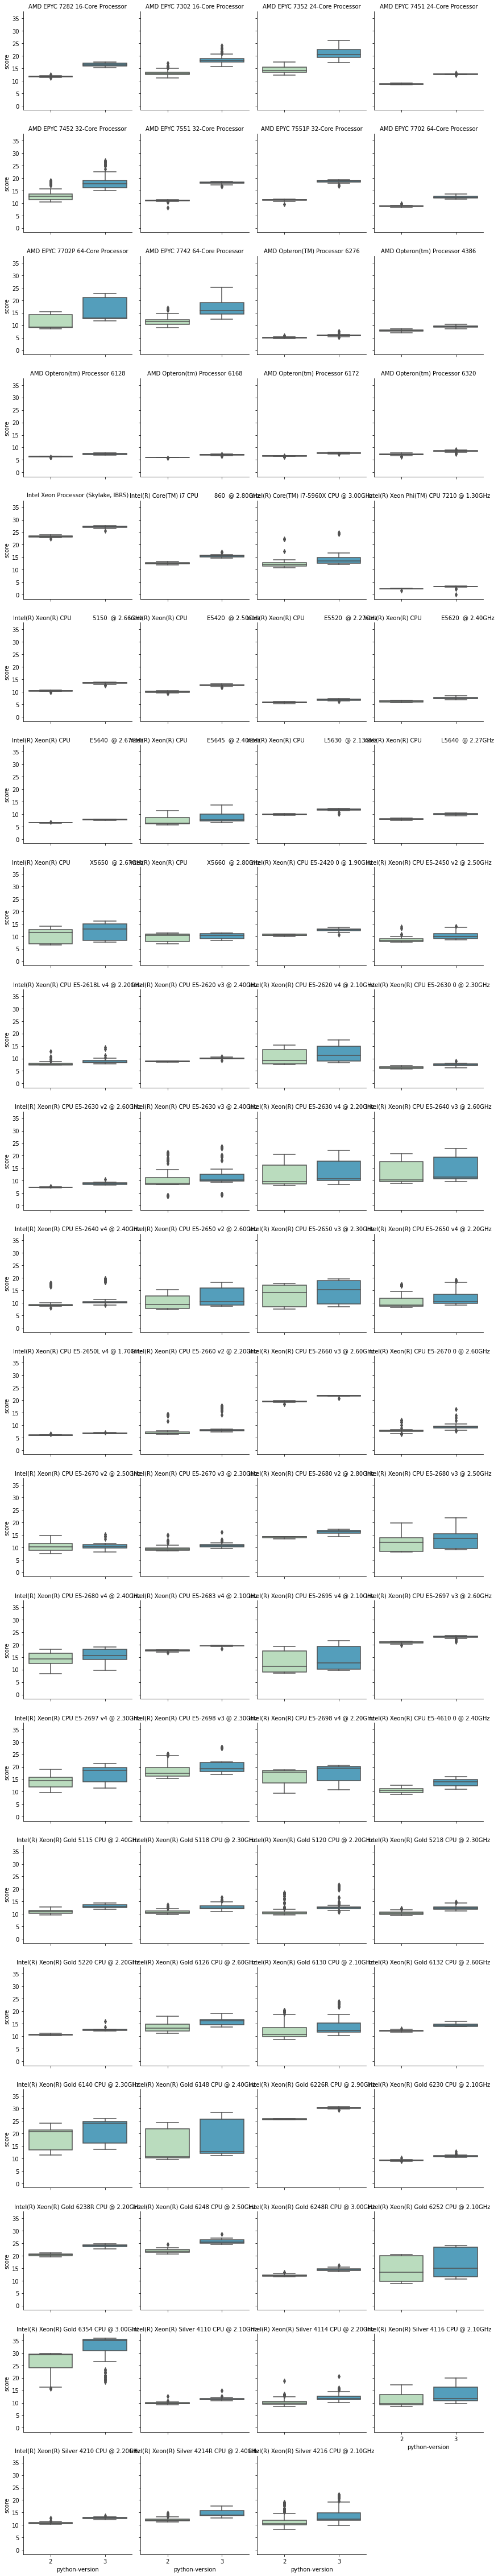

In [5]:
subdf = df.copy()
cpu_models = subdf['cpu-model'].unique()

for cpu_model in cpu_models:
    check_df = subdf[subdf['cpu-model']==cpu_model]
    count_python2 = check_df[check_df['python-version']==2]['score'].count()
    count_python3 = check_df[check_df['python-version']==3]['score'].count()

    # Only display cpu-model having at least 5 py2 and py3 results: else results are not really reliable
    if count_python2 < 5 or count_python3 < 5:
        subdf = subdf[subdf['cpu-model']!=cpu_model]

if not subdf.empty:
    g = sns.FacetGrid(subdf, col="cpu-model", margin_titles=True, col_wrap=4)
    g.map_dataframe(sns.boxplot, "python-version", "score", palette="GnBu")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
else:
    print("Not enough data")

**Distribution of the scores according to cpu model, iteration, python version and job id**

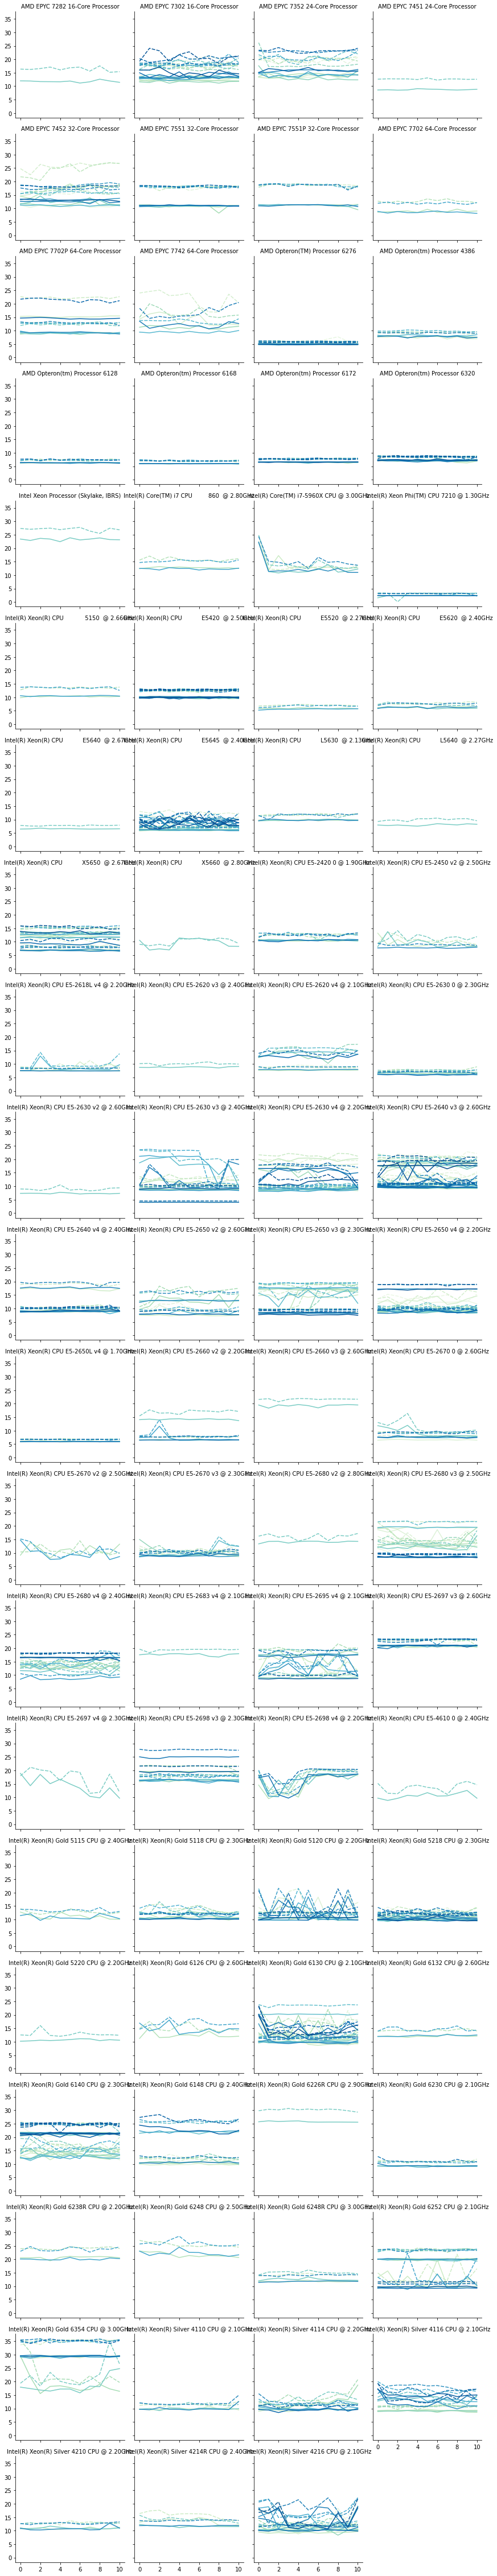

In [6]:
subdf = df.copy()
subdf['iteration'] = subdf['iteration'].astype(int)
subdf = subdf.sort_values(['iteration', 'cpu-model'])

g = sns.FacetGrid(subdf, col="cpu-model", margin_titles=True, col_wrap=4)
g.map_dataframe(sns.lineplot, x="iteration", y="score", hue="job-id", style="python-version", palette="GnBu")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

### Analysis of the scores

In [7]:
def merge_python_version(df, attrs=['job-id','iteration','ce','os','cpu-model','cpu-mhz','nb-cores','load-avg']):
    subdf_py3 = df[df['python-version']==3]
    subdf_py2 = df[df['python-version']==2]

    subdf_py3 = subdf_py3.rename(columns={'score': 'score-py3'})
    del subdf_py3['python-version']
    subdf_py3

    subdf_py2 = subdf_py2.rename(columns={'score': 'score-py2'})
    del subdf_py2['python-version']
    subdf_py2

    subdf = subdf_py3.merge(subdf_py2, how='left', on=attrs)
    return subdf

def compute_and_display_scores(df, threshold=None, y='score-py3', hue='cpu-model'):
    plt.rcParams['figure.figsize'] = [10, 10]
    
    if threshold:
        df = df[df[y] * threshold - df['score-py2'] > 0]


    scatter = sns.scatterplot(x="score-py2", y=y, hue=hue, data=df, palette="viridis")
    scatter.legend(bbox_to_anchor=(1.03, 1));

    X_plot = np.linspace(0, 30, 100)
    Y_plot = X_plot
    scatter.plot(X_plot, Y_plot, linewidth=0.5, color="r")

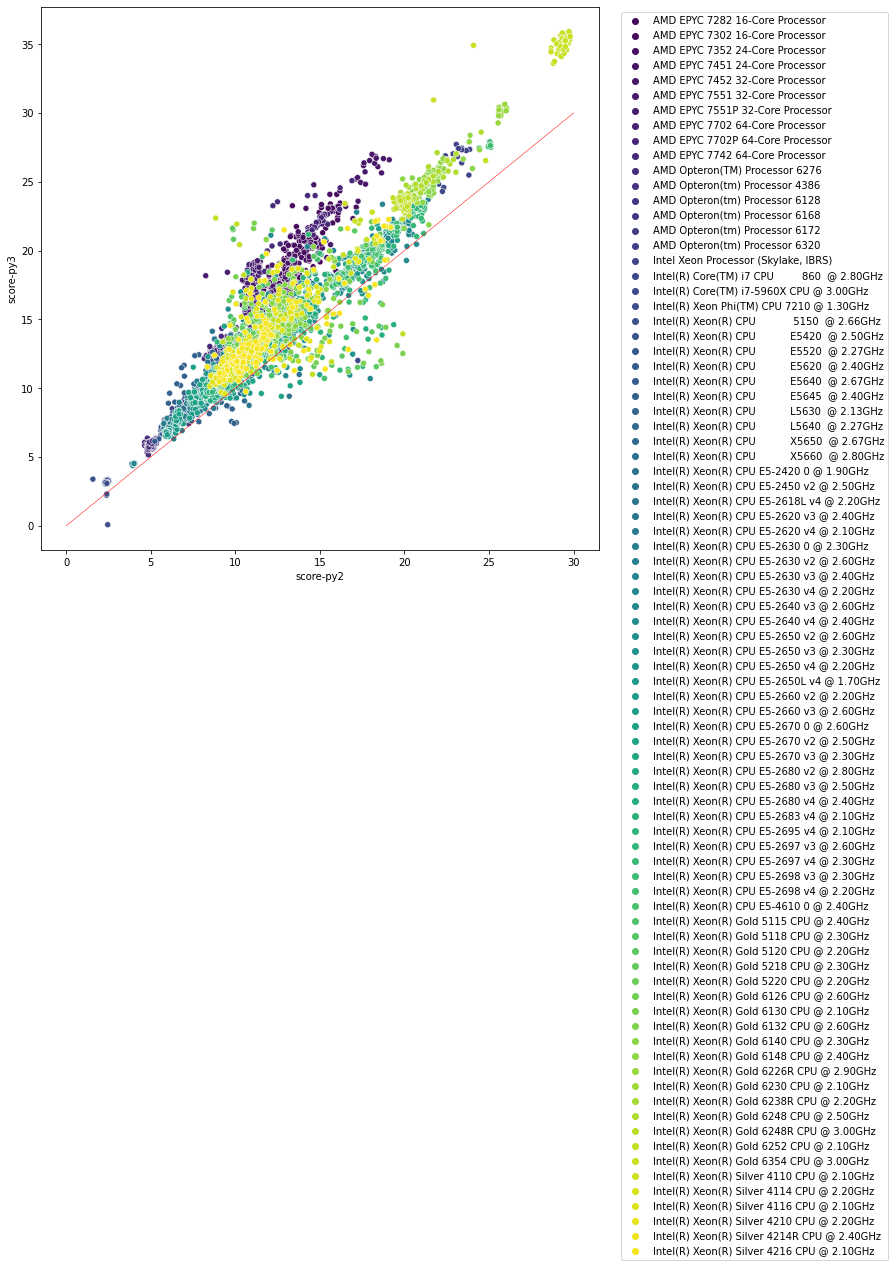

In [8]:
subdf = df.copy()
subdf = merge_python_version(subdf)
compute_and_display_scores(subdf)

In [9]:
y_test = subdf['score-py2']
predictions = subdf['score-py3']
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 2.8558366261882857


`python3` scores do not follow the `python2` scores.
We can distinguish two different lines: the Intel and the AMD ones.

In this configuration, how many jobs could fail because of a wrong estimation? (python3 score * 0.8 > python2 score)

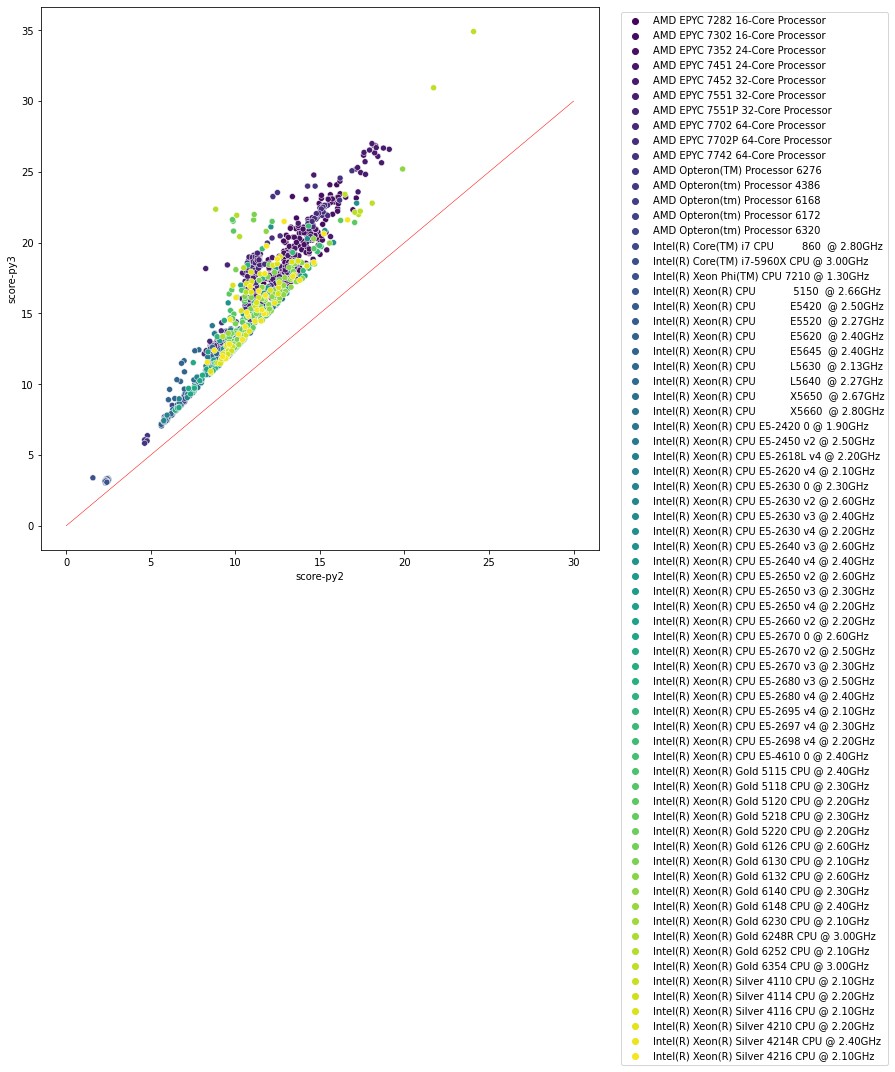

In [10]:
subdf = df.copy()
subdf = merge_python_version(subdf)
compute_and_display_scores(subdf, 0.8)

## Considered solutions

### Is there a specific and unique value that would transform a python3 score into a python2 one?

<AxesSubplot:xlabel='relation', ylabel='count'>

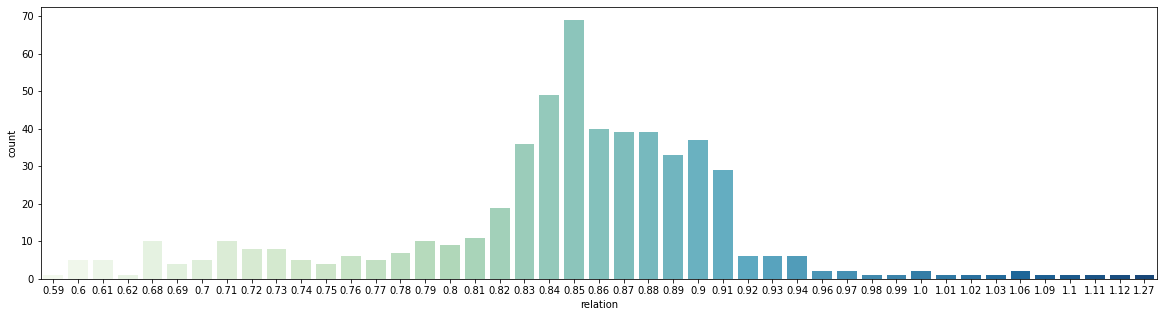

In [11]:
subdf = df.copy()
subdf = subdf.groupby(['job-id', 'python-version']).median().reset_index()
subdf = merge_python_version(subdf, ['job-id'])
subdf['relation'] = round(subdf['score-py2'] / subdf['score-py3'], 2)
plt.rcParams['figure.figsize'] = [20, 5]
sns.countplot(x='relation', data=subdf, palette='GnBu')

1.18 seems to be a good value: let's try to apply it on `python3` scores and see how it fits with pilot scores.

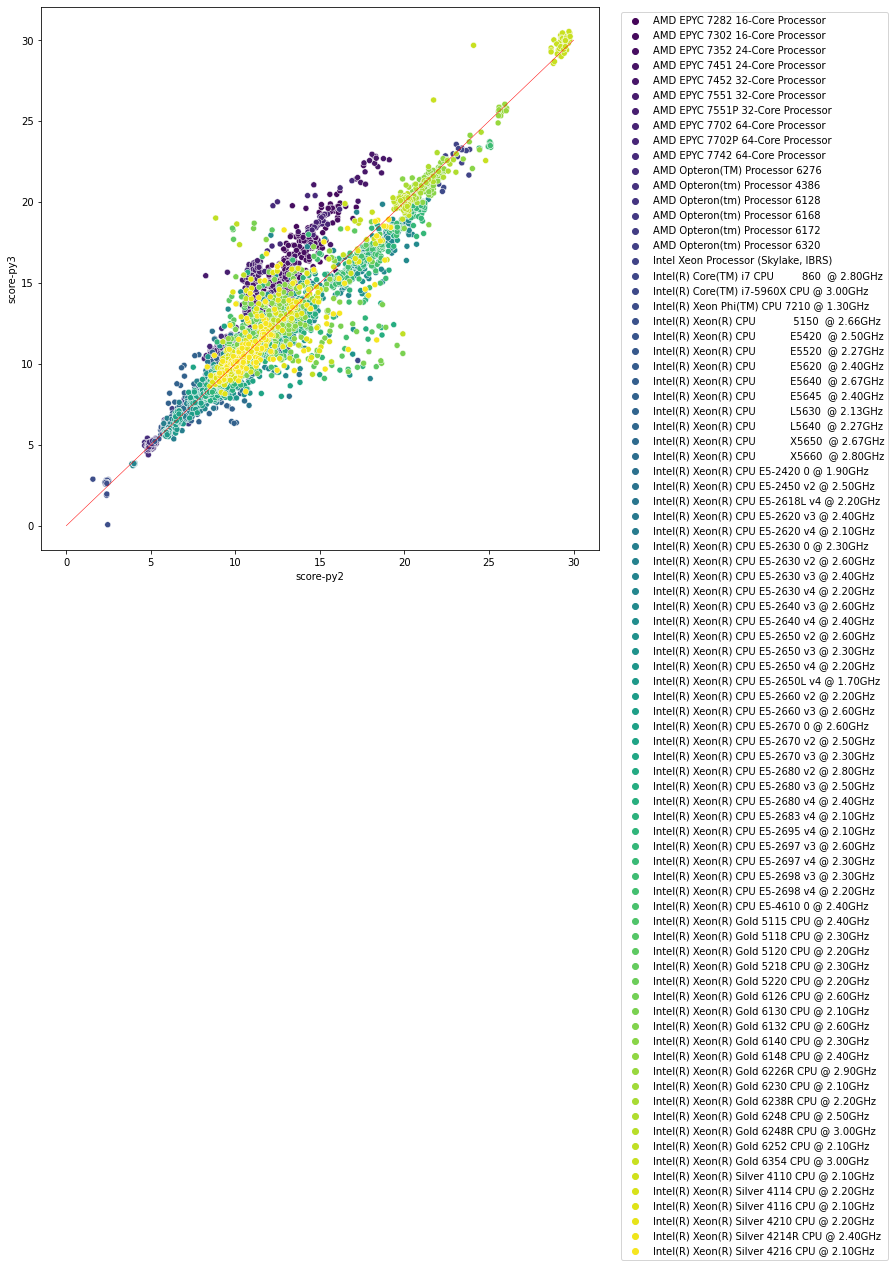

In [12]:
subdf = df.copy()
subdf.loc[subdf['python-version']==3, 'score'] = subdf['score'] * 0.85

subdf = merge_python_version(subdf)
compute_and_display_scores(subdf)

In [13]:
y_test = subdf['score-py2']
predictions = subdf['score-py3']
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1.5207597494299394


The solution seems to fit well with most of the Intel processors but not with AMD ones.
Nevertheless, scores from Intel processors seem much more volatile for some reason. 
How many jobs would fail in this new configuration?

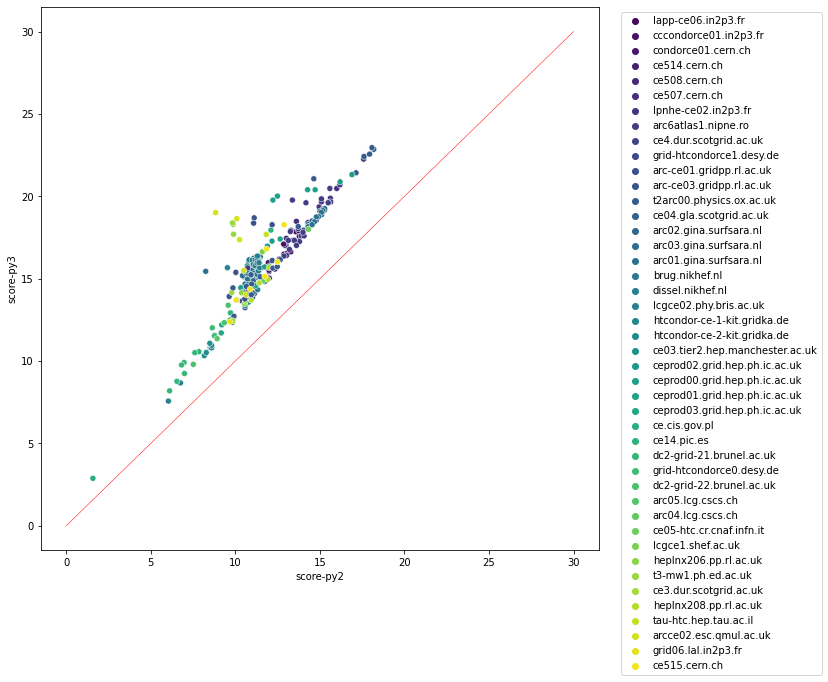

In [14]:
subdf = df.copy()
subdf.loc[subdf['python-version']==3, 'score'] = subdf['score'] * 0.85

subdf = merge_python_version(subdf)
compute_and_display_scores(subdf, 0.8, hue='ce')

### Can we have one value for Intel, and one for AMD?

Since we can distinguish two different lines, wouldn't it be better to have two different constant values? One for AMD and another for Intel.

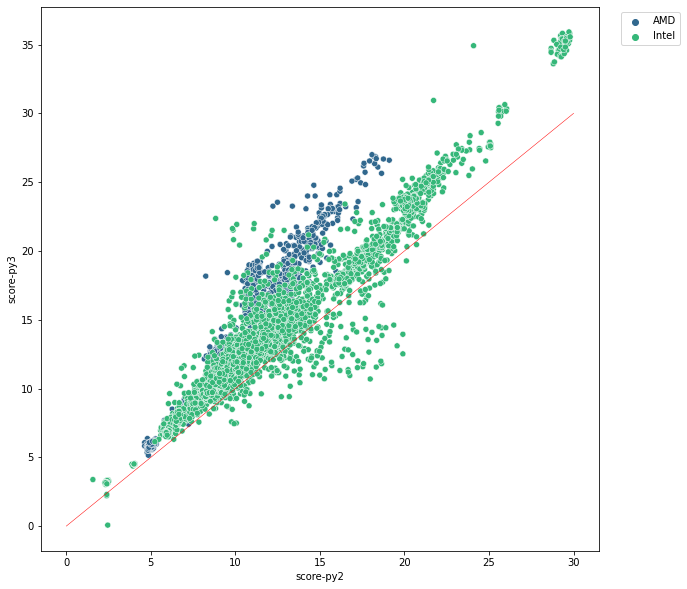

In [15]:
subdf = df.copy()
subdf = merge_python_version(subdf)
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
subdf
compute_and_display_scores(subdf, hue='cpu-family')

**Find constant values**

Let's find a constant value for AMD processors.

In [16]:
subdf = df.copy()
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
subdf = subdf.groupby(['job-id', 'cpu-family', 'python-version']).median().reset_index()
subdf = merge_python_version(subdf, ['job-id','cpu-family'])
subdf['relation'] = round(subdf['score-py2'] / subdf['score-py3'], 1)

<AxesSubplot:xlabel='relation', ylabel='count'>

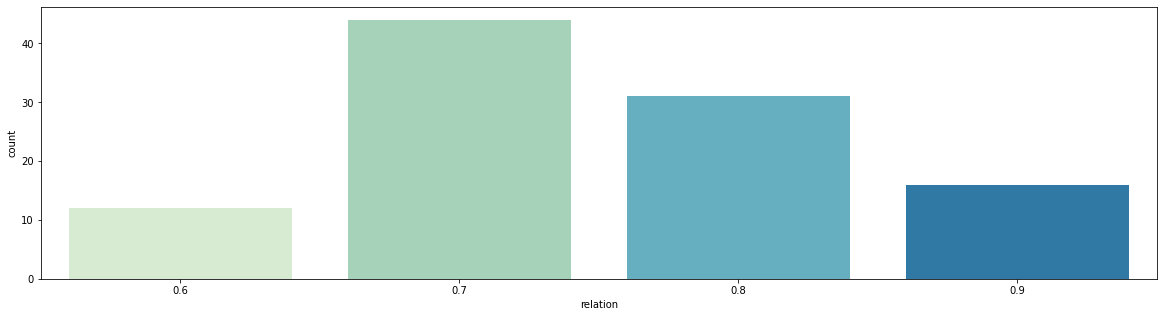

In [17]:
plt.rcParams['figure.figsize'] = [20, 5]
sns.countplot(x='relation', data=subdf[subdf['cpu-family']=='AMD'], palette='GnBu')

Most of the constant value would be between 1.2 and 1.4.
Now, let's find a constant value for Intel processor.

<AxesSubplot:xlabel='relation', ylabel='count'>

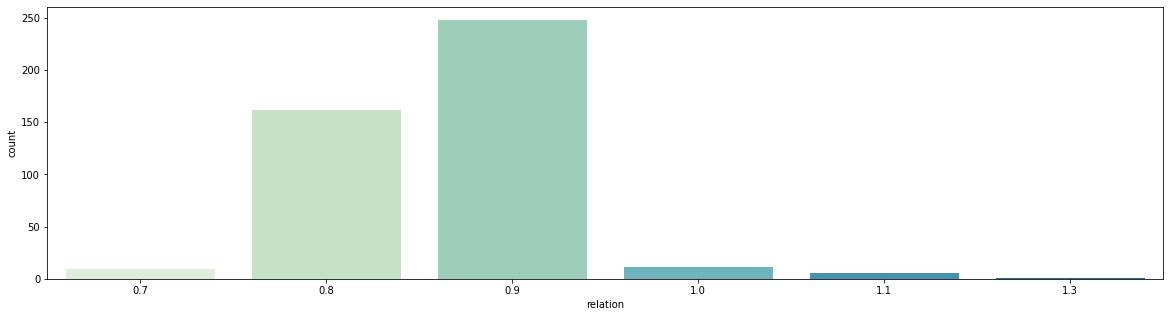

In [18]:
plt.rcParams['figure.figsize'] = [20, 5]
sns.countplot(x='relation', data=subdf[subdf['cpu-family']=='Intel'], palette='GnBu')

**Apply constants**

Intel processors only with the constant applied: 

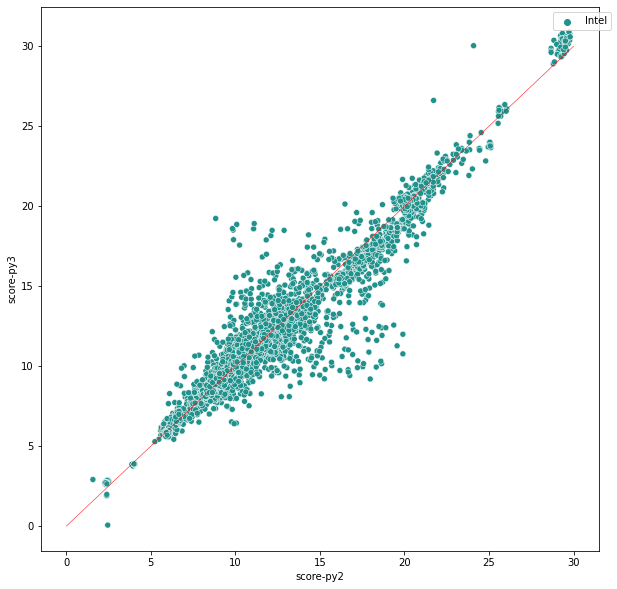

In [19]:
subdf = df.copy()
subdf.loc[subdf['python-version']==3, 'score'] = subdf['score'] * 0.86

subdf = merge_python_version(subdf)
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
compute_and_display_scores(subdf[subdf['cpu-family']=='Intel'], hue='cpu-family')

AMD processors only with the constant applied: 

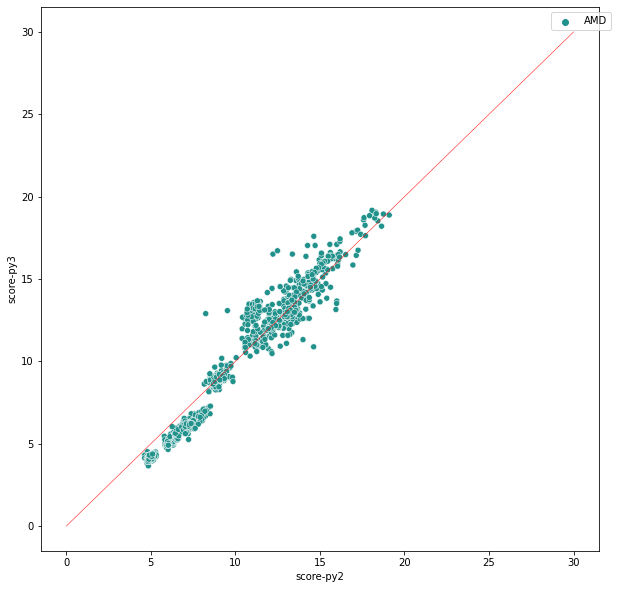

In [20]:
subdf = df.copy()
subdf.loc[subdf['python-version']==3, 'score'] = subdf['score'] * 0.71

subdf = merge_python_version(subdf)
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
compute_and_display_scores(subdf[subdf['cpu-family']=='AMD'], hue='cpu-family')

**To sum up**

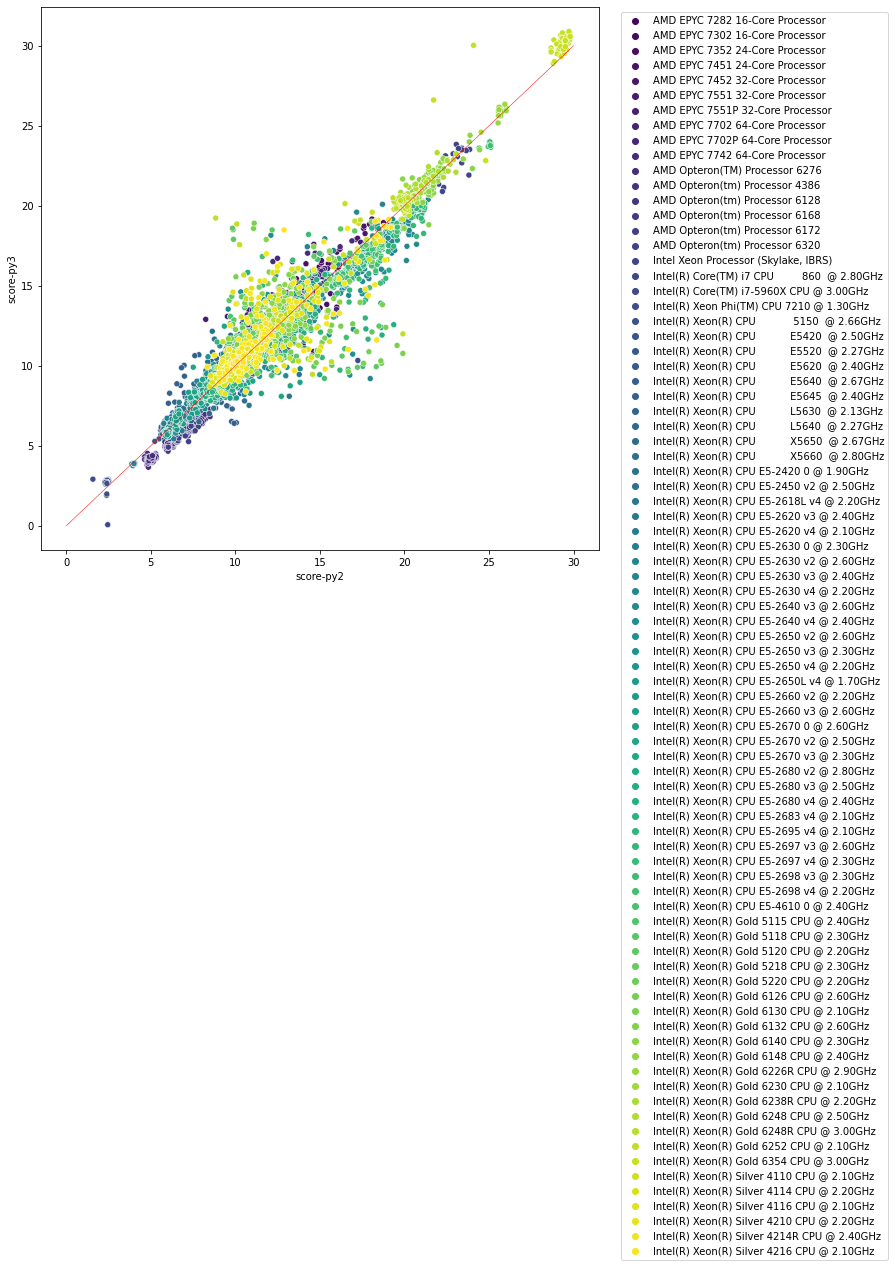

In [21]:
subdf = df.copy()
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
subdf.loc[(subdf['python-version']==3) & (subdf['cpu-family']=='AMD'), 'score'] = subdf['score'] * 0.71
subdf.loc[(subdf['python-version']==3) & (subdf['cpu-family']=='Intel'), 'score'] = subdf['score'] * 0.86
subdf = merge_python_version(subdf, ['job-id','iteration','ce','os','cpu-model','cpu-mhz','nb-cores','load-avg','cpu-family'])
compute_and_display_scores(subdf)

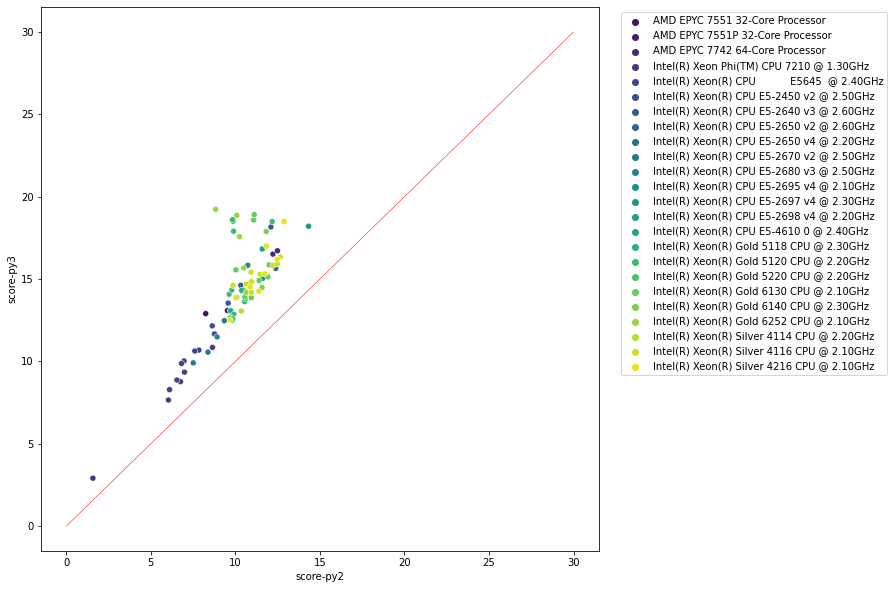

In [22]:
subdf = df.copy()
subdf['cpu-family'] = subdf.apply(lambda row: 'AMD' if 'AMD' in row['cpu-model'] else 'Intel', axis=1)
subdf.loc[(subdf['python-version']==3) & (subdf['cpu-family']=='AMD'), 'score'] = subdf['score'] * 0.71
subdf.loc[(subdf['python-version']==3) & (subdf['cpu-family']=='Intel'), 'score'] = subdf['score'] * 0.86
subdf = merge_python_version(subdf, ['job-id','iteration','ce','os','cpu-model','cpu-mhz','nb-cores','load-avg','cpu-family'])
compute_and_display_scores(subdf, 0.8)

In [23]:
y_test = subdf['score-py2']
predictions = subdf['score-py3']
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1.193533964845115


### What about creating a ML model to compute the DB12 score according to the available attributes

The idea is to find $h$ such as:
- $f(env) = DB12_{py2}$
- $g(env) = DB12_{py3}$
- $h(g(env), DB12_{py3}) = DB12_{py2}$

Pros: in the future, we might need to integrate further python versions or processors in the analysis, 
which could become harder to maintain. Having a model updated with new data regularly could simplify the process

Cons: we cannot explain what we are doing and we need a lot of data.

Let's try a simple linear regression first.

In [24]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

**Define X (the features: py3 score, os, cpu-model, cpu-mhz, ce) and y (target: py2 score)**

In [25]:
subdf = df.copy()
subdf = merge_python_version(subdf)

subdf['cpu-model'] = pd.factorize(subdf['cpu-model'])[0]
subdf['os'] = pd.factorize(subdf['os'])[0]

X = subdf[['score-py3', 'cpu-model', 'cpu-mhz', 'nb-cores', 'load-avg', 'os']]
y = subdf[['score-py2']]

**Train: regression and plot the learning curve**

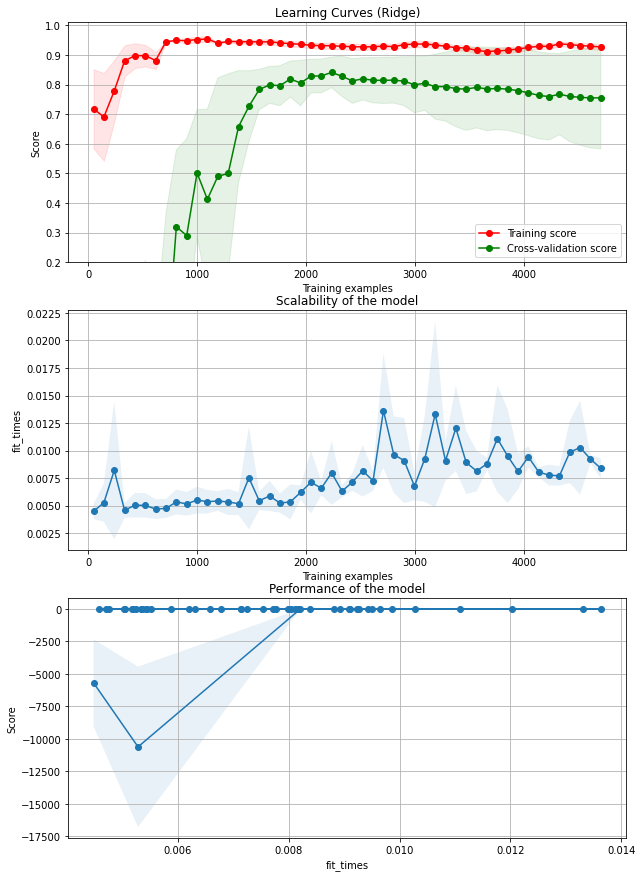

In [26]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Ridge)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
#cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LinearRegression()
plot_learning_curve(estimator, title, X, y,
                    axes=axes[:],
                    ylim=(0.2, 1.01),
                    train_sizes=np.linspace(0.01, 0.99, 50),
                    cv=5,
                    n_jobs=4)

plt.show()

We have a high-variance: we need additional data

**Train and test**

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
regr = LinearRegression()
regr.fit(X_train,y_train)
print(regr.intercept_)
print(regr.coef_)
predictions = regr.predict(X_test)

[0.02962598]
[[ 7.78258584e-01  2.73371321e-02  5.59346088e-05 -8.96167480e-03
   5.17240522e-04 -5.10918271e-02]]


In [28]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1.2542648644009329


**Plot the predictions of X_test**

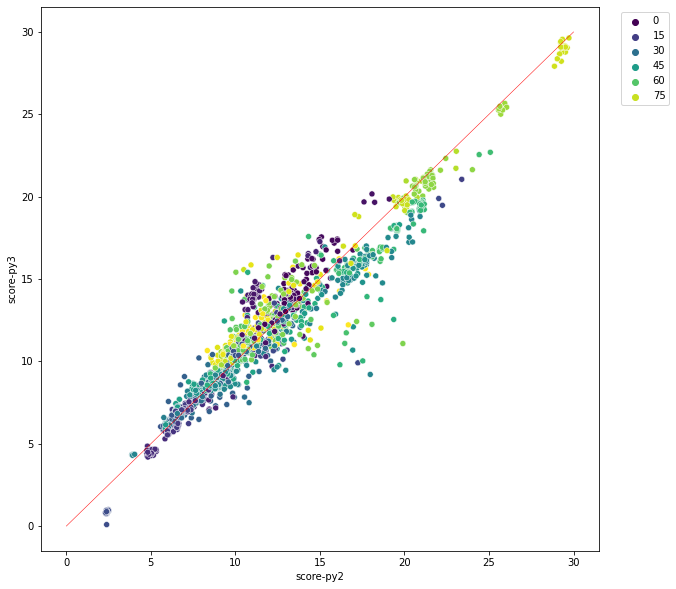

In [29]:
#predictions
subdf = X_test.copy()
subdf['score-py2'] = y_test
subdf['score-py3'] = predictions

compute_and_display_scores(subdf, None, 'score-py3', 'cpu-model')

**Plot the predictions of X**

We should not take into consideration train data but we include them to have a bigger picture.

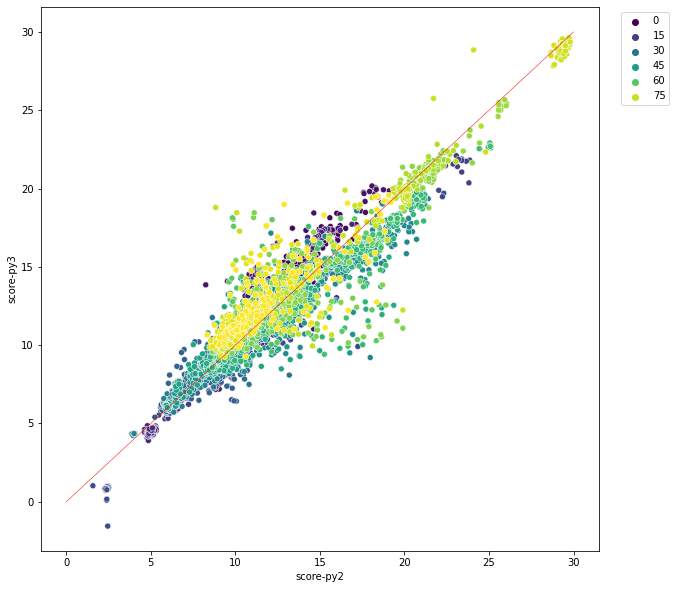

In [30]:
predictions = regr.predict(X)
subdf = X.copy()
subdf['score-py2'] = y
subdf['score-py3'] = predictions

compute_and_display_scores(subdf, None, 'score-py3', 'cpu-model')

In [31]:
y_test = subdf['score-py2']
predictions = subdf['score-py3']
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 1.301812455645645


How many jobs would fail in this configuration?

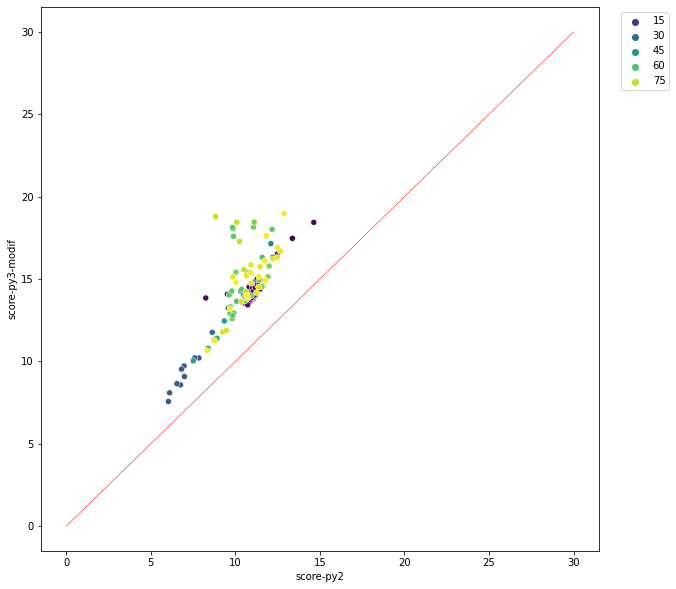

In [32]:
predictions = regr.predict(X)
subdf = X.copy()
subdf['score-py2'] = y
subdf['score-py3-modif'] = predictions

compute_and_display_scores(subdf, 0.8, 'score-py3-modif', 'cpu-model')